## Time Series
Mathieu Laversin Alexandra Mille-Egea Ryan Pégoud

November 2022

In this work, we will apply the theory learned in Time Series on the next dataset : https://www.kaggle.com/datasets/francoisraucent/western-europe-power-consumption

In this Western Europe Power Consumption dataset, we will study the France consumption and try to predict it over months. The consumption is given in Megawatts (MW) and goes from January 2015 up to August 2020. The periodicity is about 1 hour between each sample.

In order to get the possibility to check our results, we will predict the power consumption in France in 2020.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('fr.csv')
df.head()

,start,end,load
0,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+00:00,70929.0
1,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+00:00,69773.0
2,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+00:00,66417.0
3,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+00:00,64182.0
4,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+00:00,63859.0


# **Descriptive analysis**

In [4]:
df.describe()

,load
count,48870.000000
mean,53556.308267
std,11682.584881
min,29398.000000
25%,44616.000000
50%,51932.000000
75%,61629.750000
max,158000.000000


# **Down sampling**

In [5]:
df['start'] = pd.to_datetime(df['start'], format='%Y/%m/%d %H:%M:%S')
df['end'] = pd.to_datetime(df['end'], format='%Y/%m/%d %H:%M:%S')

df.set_index('start', inplace=True)
df

,end,load
start,,
2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+00:00,70929.0
2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+00:00,69773.0
2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+00:00,66417.0
2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+00:00,64182.0
2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+00:00,63859.0
...,...,...
2020-07-31 19:00:00+00:00,2020-07-31 20:00:00+00:00,46001.0
2020-07-31 20:00:00+00:00,2020-07-31 21:00:00+00:00,47535.0
2020-07-31 21:00:00+00:00,2020-07-31 22:00:00+00:00,47322.0


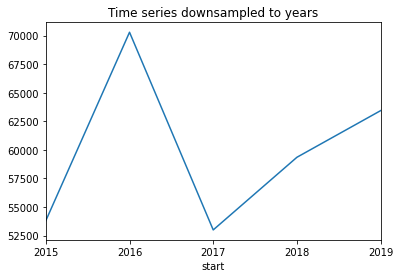

In [6]:
df["load"].asfreq('Y').plot()
plt.title('Time series downsampled to years')
plt.show()

In [7]:
df['year'] = pd.DatetimeIndex(df.index).year
yearly = df.groupby('year').agg('sum')
yearly

,load
year,
2015,470012917.0
2016,477474024.0
2017,475934939.0
2018,470394794.0
2019,467000414.0
2020,256479697.0


# **Monthly Moving Averages**

In [8]:
df['month'] = pd.DatetimeIndex(df.index).month
df_month_year= df.groupby(['year','month']).agg('mean')
df_month_year

load
year month              
2015 1      69523.116935
     2      71374.474702
     3      60624.438172
     4      50608.841667
     5      45209.040377
...                  ...
2020 3      55252.318489
     4      42409.579167
     5      40946.911290
     6      42225.624478
     7      44123.798387

[67 rows x 1 columns]

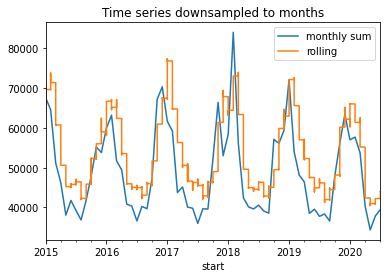

In [9]:
df["load"].asfreq('M').plot(label='monthly sum')

rolling_load = df.load.rolling('30D').mean()
rolling_load.plot(label='rolling')
plt.legend()
plt.title('Time series downsampled to months')
plt.show()

# **Seasonality**

In [10]:
melted_y_m = df.melt(id_vars=['year','month'], value_vars='load').drop('variable',axis=1)
melted_means = melted_y_m.groupby(['year','month']).agg('mean')
melted_means

value
year month              
2015 1      69523.116935
     2      71374.474702
     3      60624.438172
     4      50608.841667
     5      45209.040377
...                  ...
2020 3      55252.318489
     4      42409.579167
     5      40946.911290
     6      42225.624478
     7      44123.798387

[67 rows x 1 columns]

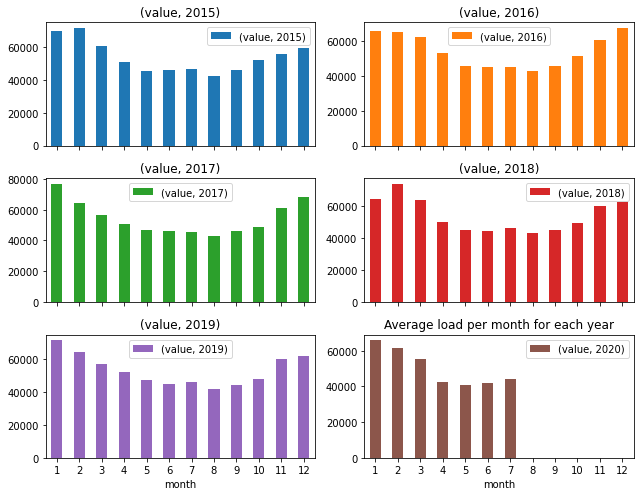

In [11]:
melted_means.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(3,2))
plt.title('Average load per month for each year')
plt.tight_layout()

In [12]:
melted_means['year'] = [melted_means.index[i][0] for i in range(melted_means.shape[0])]

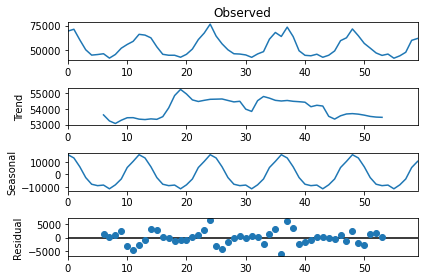

In [13]:
import statsmodels.api as sm

values = melted_means[melted_means['year']<2020]['value'] # monthly means between 2015 and 2019 (2020 is incomplete)
values = np.array(values, dtype=object)
decomposed = sm.tsa.seasonal_decompose(values, period=12) # yearly seasonality
decomposed.plot()
plt.show()

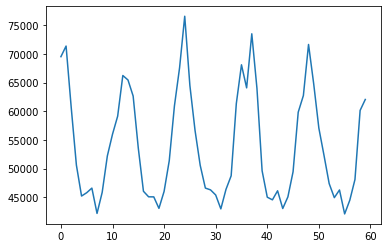

In [14]:
plt.plot(values)

In [15]:
train = melted_means[melted_means['year']<2018]
test = melted_means[melted_means['year'].between(2018,2020)]

In [16]:
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# model = ExponentialSmoothing(values, trend='add')
# model_fit = model.fit()
# yhat = model_fit.predict(...)

The training dataset has the dates from January 1st 2015 to December 31th, 2017, and the testing dataset has the dates from January 1st, 2018 to July 31, 2020.

In [17]:
# check shape
print(train.shape)
print(test.shape)

(36, 2)
(31, 2)


In [18]:
# Check the start and end time of the training and testing dataset
print('The start time of the training dataset is ', train['year'].min())
print('The end time of the training dataset is ', train['year'].max())
print('The start time of the testing dataset is ', test['year'].min())
print('The end time of the testing dataset is ', test['year'].max())


The start time of the training dataset is  2015
The end time of the training dataset is  2017
The start time of the testing dataset is  2018
The end time of the testing dataset is  2020


In [19]:
# read csv again (to convert it after in the good format for the prophet model)
df_ds = pd.read_csv('fr.csv')
df_ds.head()
df_ds=df_ds.drop(["end"], axis=1)


In [20]:
df_ds['start'] = pd.to_datetime(df_ds['start'], format='%Y/%m/%d %H:%M:%S')
df_ds.set_index('start', inplace=False)
df_ds

,start,load
0,2015-01-01 00:00:00+00:00,70929.0
1,2015-01-01 01:00:00+00:00,69773.0
2,2015-01-01 02:00:00+00:00,66417.0
3,2015-01-01 03:00:00+00:00,64182.0
4,2015-01-01 04:00:00+00:00,63859.0
...,...,...
48865,2020-07-31 19:00:00+00:00,46001.0
48866,2020-07-31 20:00:00+00:00,47535.0
48867,2020-07-31 21:00:00+00:00,47322.0
48868,2020-07-31 22:00:00+00:00,42805.0


In [21]:
# data re-sampled based on each day
df_ds = df_ds.resample('D', on='start').load.sum()


In [22]:
# reconvert to dataframe
df_ds = pd.DataFrame(df_ds)
df_ds.head()

,load
start,
2015-01-01 00:00:00+00:00,1592885.0
2015-01-02 00:00:00+00:00,1637422.0
2015-01-03 00:00:00+00:00,1510660.0
2015-01-04 00:00:00+00:00,1404165.0
2015-01-05 00:00:00+00:00,1708152.0


In [23]:
# rename columns for prophet model
df_ds = df_ds.reset_index()
df_ds.columns = ['ds', 'y']
df_ds.head()

,ds,y
0,2015-01-01 00:00:00+00:00,1592885.0
1,2015-01-02 00:00:00+00:00,1637422.0
2,2015-01-03 00:00:00+00:00,1510660.0
3,2015-01-04 00:00:00+00:00,1404165.0
4,2015-01-05 00:00:00+00:00,1708152.0


In [24]:
# remove timezone
def remove_timezone(df):
   
    # HERE `df` is a python datetime
    # object that used .replace() method
    return df.replace(tzinfo=None)
    
df_ds['ds'] = df_ds['ds'].apply(remove_timezone)

In [32]:
train_end_date = '2018-01-01'

# Train test split
train = df_ds[df_ds['ds'] <= train_end_date]
test = df_ds[df_ds['ds'] > train_end_date]
train.shape

(1097, 2)

## Global model


Prophet : https://facebook.github.io/prophet/ 

The official Prophet homepage states that :

__Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.__

The advantages of this model are that :
This model is fast and accurate, it is automatic, we can modify some parameters and obtain quickly an overview of the forecast. In  our case, it can be used in complementary of our manual work.

In [26]:
# generate a model

# Prophet model for time series forecast
!pip install prophet
from prophet import Prophet
# Use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()# Fit the model on the training dataset
model_baseline.fit(train)

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\alexa\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\prophet\\stan_model\\cmdstan-2.26.1\\stan\\lib\\stan_math\\lib\\tbb_2019_U8\\include\\tbb\\internal\\_flow_graph_tagged_buffer_impl.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



  Using cached prophet-1.1.1-cp310-cp310-win_amd64.whl (12.1 MB)

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: C:\Users\alexa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
16:05:17 - cmdstanpy - INFO - Chain [1] start processing
16:05:17 - cmdstanpy - INFO - Chain [1] done processing


Below, we can visualize our initial data until 2018, and the forecast after. We can easily observe that, bigger the prediction is in days, bigger are the errors.
We can see graphically that the preidction seems to follow the expectations (for predictions equals or less to one year). Let's have a look on errors and accuracy of the Prophet model.

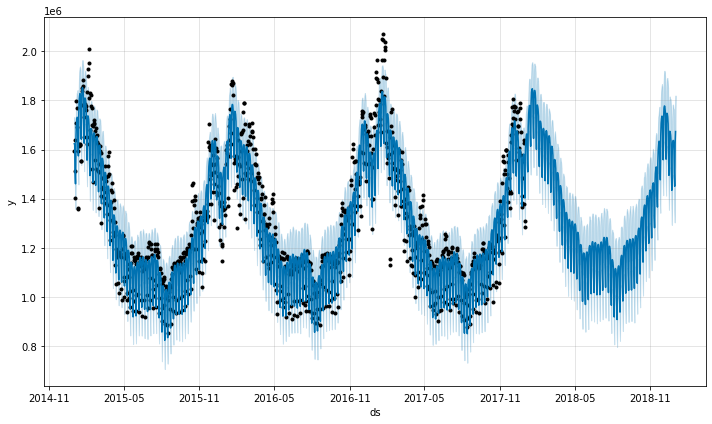

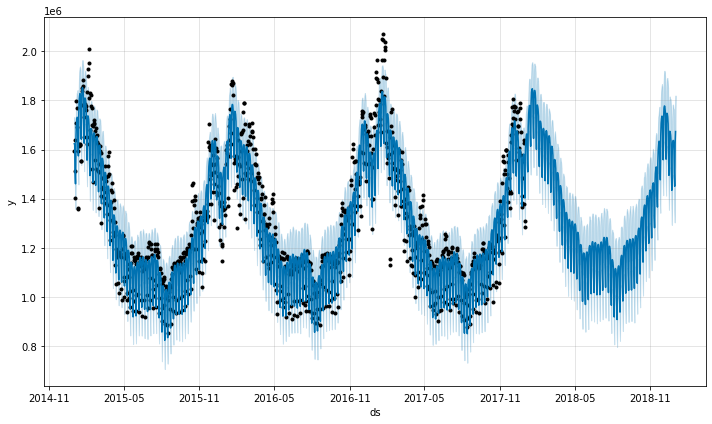

In [61]:
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=365) # Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
model_baseline.plot(forecast_baseline) # visualize it

The trend isn't smooth at all over the years. We could smooth it before giving it to the model. The predicted trend follows the last 'trend coeffecient ax+b'. This can works for small preidctions (maybe one month or two). However, on bigger predictions (one year and more), the trend is really uncertain and not reliable at all. It is better to forecast on few months or less to get reliable results.

We can't remove the weekly graph, it is useless in our study.

On the last graph (yearly), we can see the influence ("weight") of a month in the prediction. For example, January influences positively the power consumption and August downs the global consumption. This curve is in agreement with what we expect (and observe above). The power consumption increases in winter and decreases otherwise. We also see that we have no incertainty on the seasons, that don't change over years, contrary to the trend.



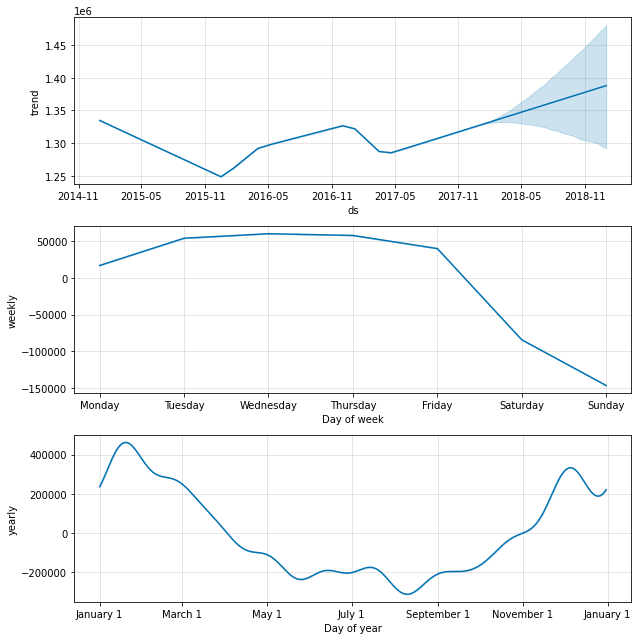

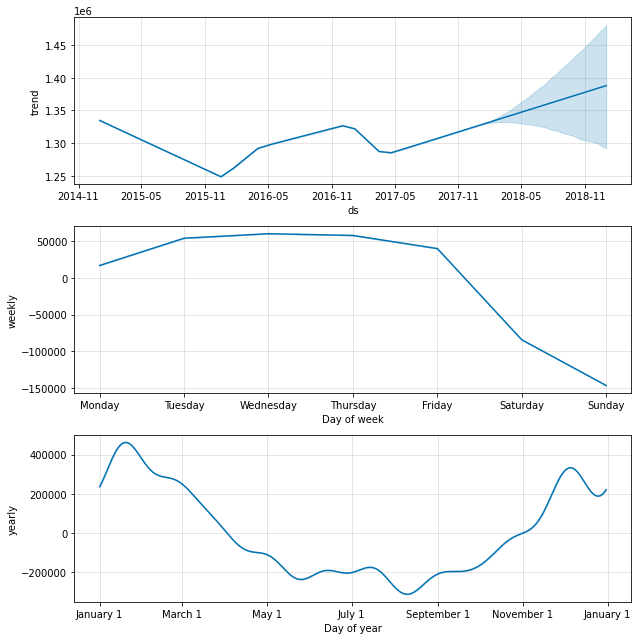

In [62]:
# plot the components of the model (trend and seasons)

model_baseline.plot_components(forecast_baseline, weekly_start=1)

We can see below a comparison between the prediction (yhat) and the true value (y). The next table gives the percentage error on the predictions made.

In [52]:
# make a cross validation to compare prediction and true values

from prophet.diagnostics import cross_validation

df_cv = cross_validation(model_baseline, initial='730 days',
                         period='180 days', horizon = '30 days')

df_cv.head()


  0%|          | 0/2 [00:00<?, ?it/s]16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  1.43it/s]16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-06-06,1.105196e+06,999791.952681,1.219514e+06,1092558.0,2017-06-05
1,2017-06-07,1.112208e+06,998308.211562,1.226598e+06,1110836.0,2017-06-05
2,2017-06-08,1.109957e+06,997828.348004,1.213302e+06,1130834.0,2017-06-05
3,2017-06-09,1.093319e+06,988778.134802,1.208254e+06,1124029.0,2017-06-05
4,2017-06-10,9.668743e+05,847951.070941,1.077632e+06,1005885.0,2017-06-05


In [53]:
# give the performance of the model through different loss functions, depending on the amount of days prediction (horizon)

from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.476533e+10,121512.683686,86838.243858,0.052000,0.037602,0.054647,0.666667
1,4 days,7.769289e+09,88143.568253,69182.865127,0.041927,0.042032,0.043265,0.833333
2,5 days,6.445328e+09,80282.800858,69585.436432,0.044918,0.047762,0.046121,0.833333
3,6 days,6.502213e+09,80636.299102,72761.746581,0.049670,0.051860,0.051030,0.833333
4,7 days,9.466865e+09,97297.817564,87686.451369,0.061099,0.057092,0.063210,0.666667


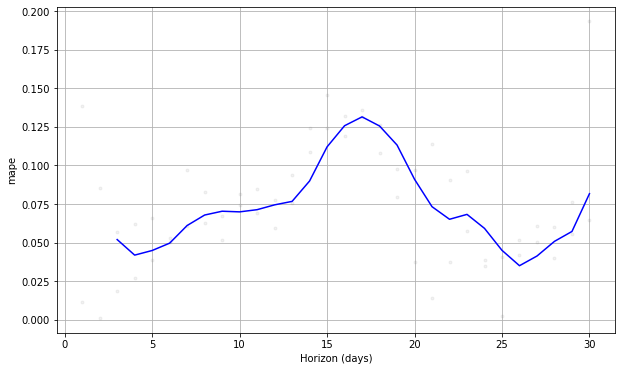

In [63]:
# plot mape error

from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

Definition of 'mape' from Encyclopedia of Production and Manufacturing Management : 

The mean absolute percentage error (MAPE) is the mean or average of the absolute percentage errors of forecasts. Error is defined as actual or observed value minus the forecasted value. Percentage errors are summed without regard to sign to compute MAPE. This measure is easy to understand because it provides the error in terms of percentages. Also, because absolute percentage errors are used, the problem of positive and negative errors canceling each other out is avoided.

The maximum of the mape is about 0.13 percent, and the min is less that 0.05 percent of error, which is pretty good. However, we could expect to see the error increasing over the days amount of predictions. It is not the case, we get more erros after 15 days than after 23, which is strange. We can observe this same phenomen with other types of errors, as MSE or RMSE. Ignoring this detail, our model seems good to predict over a month the power consumption in France.

In [58]:
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
 |      flat trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selec